In [17]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
%matplotlib inline
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
Apikey = 'EK968A2XHRMFJY8J'
 

def alpha_vantage_eod(symbol_list, compact=False, debug=False, *args, **kwargs):
    '''
    Helper function to download Alpha Vantage Data.
 
    This will return a nested list with each entry containing:
        [0] pandas dataframe
        [1] the name of the feed.
    '''
    data_list = list()
 
    size = 'compact' if compact else 'full'
 
    for symbol in symbol_list:
 
        if debug:
            print('Downloading: {}, Size: {}'.format(symbol, size))
 
        # Submit our API and create a session
        alpha_ts = TimeSeries(key=Apikey, output_format='pandas')
 
        data, meta_data = alpha_ts.get_daily(symbol=symbol, outputsize=size)
 
        #Convert the index to datetime.
        data.index = pd.to_datetime(data.index)
        data.columns = ['Open', 'High', 'Low', 'Close','Volume']
 
        if debug:
            print(data)
 
        data_list.append((data, symbol))
 
    return data_list
 
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        #print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

if __name__ == '__main__':
    # Create an instance of cerebro
    cerebro = bt.Cerebro()

    # Add our strategy
    cerebro.addstrategy(TestStrategy)

    # Download our data from Alpha Vantage.
    symbol_list = ['SPX']
    data_list = alpha_vantage_eod(
                    symbol_list,
                    compact=False,
                    debug=False)

    for i in range(len(data_list)):

        data = bt.feeds.PandasData(
                    dataname=data_list[i][0], # This is the Pandas DataFrame
                    name=data_list[i][1], # This is the symbol
                    timeframe=bt.TimeFrame.Days,
                    compression=1,
                    fromdate=datetime.datetime(2015,1,1),
                    todate=datetime.datetime(2017,12,31)
                    )

        #Add the data to Cerebro
        cerebro.adddata(data)

        # Set our desired cash start
        cerebro.broker.setcash(100000.0)
        
        # Set the commission - 0.1% ... divide by 100 to remove the %
        cerebro.broker.setcommission(commission=0.001)
        
        # Add a FixedSize sizer according to the stake
        cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    
        # Print out the starting conditions
        print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

        # Run over everything
        cerebro.run()

        # Print out the final result
        print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 97457.60


<IPython.core.display.Javascript object>


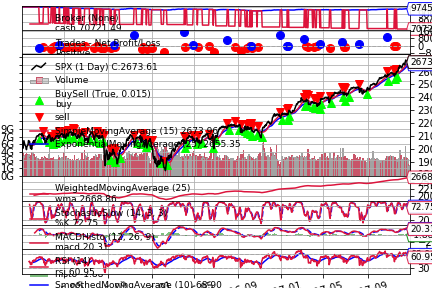

[[<Figure size 432x288 with 8 Axes>]]

In [18]:
cerebro.plot()